In [32]:
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt
import pandas as pd
import pickle
import dnnlib
import dnnlib_util
import lpips

import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torchvision.io import read_image

%matplotlib inline

In [2]:
START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3
BATCH_SIZES = [256,256,128,64,32,16,16]
CHANNELS_IMG = 3
Z_DIM = 512
W_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [30] * len(BATCH_SIZES)

DATASETROOT = "./256x256"

In [3]:
class FFHQDataset(Dataset):
    """ Dataset to load FFHQ data from a dataframe

    Args:

        dataframe : dataframe with image paths in column 'image_path'
        datasetRoot : the root path to join before the image_path, if any.
        res : resolution of the image generated
    
    """
    def __init__(self, dataframe, datasetRoot, transform, res = 2, device = "cuda:0") -> None:
        super().__init__()
        self.dataframe = dataframe
        self.datasetRoot = datasetRoot
        self.res = res
        self.device = torch.device(device)

        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index) :
        img_path = os.path.join(self.datasetRoot,self.dataframe['image_path'].iloc[index])
        image = read_image(img_path)
        return self.transform(image).to(self.device)

In [4]:
def process_filepath(x:str):
    x = x.replace(".png",".jpg")
    x = x.split("/")
    x.pop(1)
    return "/".join(x)


data = pd.read_json(os.path.join(DATASETROOT,"ffhq-dataset-v2.json"),orient="index")
data['image_path'] = data.apply(lambda x : process_filepath(x['thumbnail']['file_path']),axis=1)
data = data.drop(columns=['image','thumbnail','in_the_wild','metadata'])


In [4]:
def get_loader(image_size,data,dataType="training") -> DataLoader:
    trainsform = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.Resize((image_size, image_size)),
         transforms.ToTensor(),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)],
            [0.5 for _ in range(CHANNELS_IMG)],
         )
        ]
    )

    data = data.loc[data['category']==dataType].drop(columns=['category'])

    batch_size = BATCH_SIZES[int(log2(image_size/4))]
    dataset  = FFHQDataset(data, DATASETROOT,trainsform, image_size)
    return DataLoader(dataset,batch_size=batch_size, shuffle= True), dataset

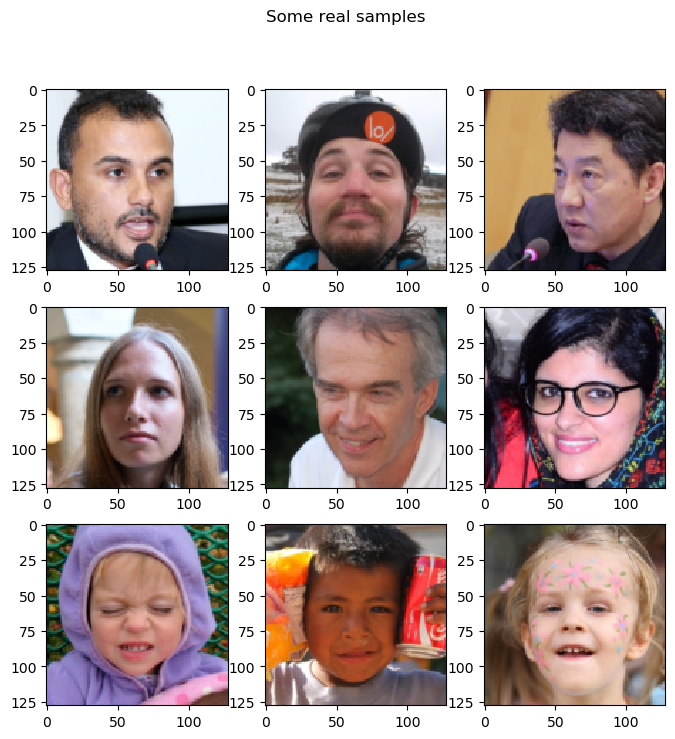

In [6]:
def check_loader():
    loader,_ = get_loader(128,data)
    img  = next(iter(loader))
    img = img.cpu().detach()
    _,ax     = plt.subplots(3,3,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((img[ind].permute(1,2,0)+1)/2)
            ind +=1
    plt.show()
check_loader() 

In [5]:
factors = [1,1,1,1/2,1/4,1/8,1/16,1/32]

In [6]:
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features
    ):
        super(WSLinear,self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale  = (2/in_features) ** 0.5
        self.bias   = self.linear.bias
        self.linear.bias = None

        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias


class PixenNorm(nn.Module):
    def __init__(self):
        super(PixenNorm, self).__init__()
        self.epsilon = 1e-8
    def forward(self,x ):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+  self.epsilon)

class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixenNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )
    
    def forward(self,x):
        return self.mapping(x)

class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale   = WSLinear(w_dim, channels)
        self.style_bias    = WSLinear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias

class injectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + self.weight + noise

class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x

In [7]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel)
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = injectNoise(out_channel)
        self.inject_noise2 = injectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        self.map = MappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = injectNoise(in_channels)
        self.initial_noise2 = injectNoise(in_channels)
        self.initial_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky          = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb    = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))
        
    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha ) * upscaled)

    def forward(self, noise, alpha, steps , applyMap = True):
        if applyMap:
            w = self.map(noise)
        else:
            w = noise
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)
        
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode = 'bilinear')
            out      = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out      = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)

In [8]:

class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [9]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()


In [10]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen
):
    loop = tqdm(loader, leave=True)

    for batch_idx, real in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        fake  = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha,1)


        loop.set_postfix(
            gp = gp.item(),
            loss_critic = loss_critic.item()
        )
    return alpha


# Training

In [19]:
gen = Generator(
    Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.0, 0.99)
)

gen.load_state_dict(torch.load("./generator_256_3"))
critic.load_state_dict(torch.load("./critic_256_3"))
    
gen.train()
critic.train()

alpha = 1e-7
step = 6
loader, dataset = get_loader(4*2**step, data)
print('Curent image size: '+str(4*2**step))
num_epochs = 30
for epoch in range(num_epochs):
    print(f'Epoch [{epoch + 1}/ {num_epochs}')
    alpha = train_fn(
        critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen
    )
    generate_examples(gen, step)

Curent image size: 256
Epoch [1/ 30


  0%|          | 0/3750 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 5.81 GiB total capacity; 3.85 GiB already allocated; 209.06 MiB free; 4.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
gen = Generator(
    Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.0, 0.99)
)

gen.train()
critic.train()

step = int(log2(START_TRAIN_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-7
    loader, dataset = get_loader(4*2**step, data)
    print('Curent image size: '+str(4*2**step))

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch + 1}/ {num_epochs}')
        alpha = train_fn(
            critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen
        )
    generate_examples(gen, step)
    step +=1



# Testing & Evaluation

In [11]:
gen = Generator(
    Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.0, 0.99)
)

gen.eval()
critic.eval()

Discriminator(
  (prog_blocks): ModuleList(
    (0): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (leaky): LeakyReLU(negative_slope=0.2)
    )
    (1): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (leaky): LeakyReLU(negative_slope=0.2)
    )
    (2): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (leaky): LeakyReLU(nega

In [12]:
gen.load_state_dict(torch.load("./custom_stylegan/generator_256_3_60"))
critic.load_state_dict(torch.load("./custom_stylegan/critic_256_3_60"))

<All keys matched successfully>

## Style Mixing

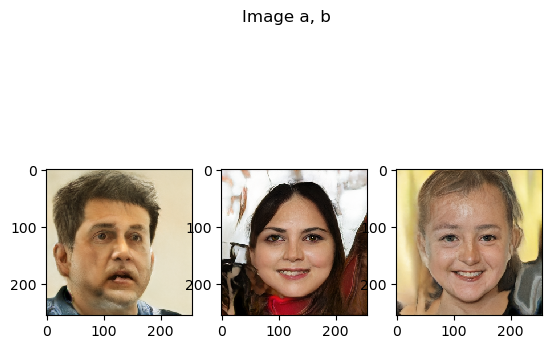

In [25]:
alpha = 1.0
steps = 6

noise_a = torch.randn(1, Z_DIM).to(DEVICE)
noise_b = torch.randn(1, Z_DIM).to(DEVICE)

img_a = (gen(noise_a, alpha, steps)* 0.5 + 0.5).cpu().detach()[0].permute(1,2,0)
img_b = (gen(noise_b, alpha, steps)* 0.5 + 0.5).cpu().detach()[0].permute(1,2,0)

img_mixed = (gen(noise_a*0.5 + noise_b*0.5, alpha, steps)* 0.5 + 0.5).cpu().detach()[0].permute(1,2,0)

_,ax     = plt.subplots(1,3)
plt.suptitle('Image a, b')
ind = 0
ax[0].imshow(img_a)
ax[1].imshow(img_b)
ax[2].imshow(img_mixed)
plt.show()


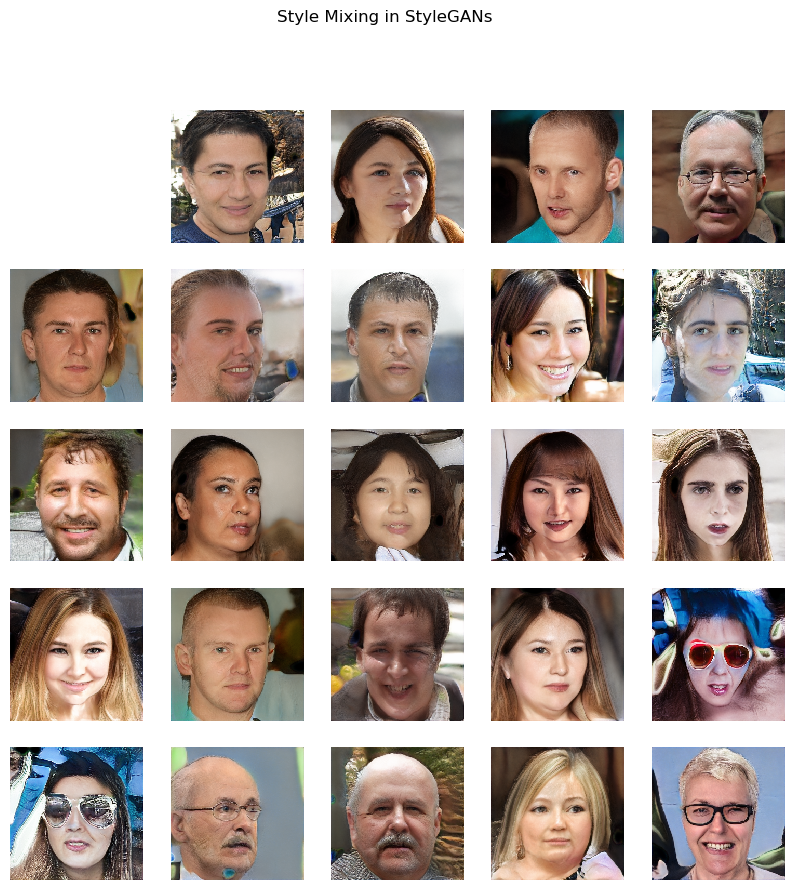

In [28]:
noise_a = []
noise_b = []
for i in range(0,4):
    noise_a.append(torch.randn(1, Z_DIM).to(DEVICE))
    noise_b.append(torch.randn(1, Z_DIM).to(DEVICE))

_,ax     = plt.subplots(5,5, figsize = (10,10))
plt.suptitle('Style Mixing in StyleGANs')

for i in ax:
    for j in i:
        j.axis("off")

for i in range(1,5):
    img = (gen(noise_a[i-1], alpha, steps)* 0.5 + 0.5).cpu().detach()[0].permute(1,2,0)
    ax[0][i].imshow(img)

    img = (gen(noise_b[i-1], alpha, steps)* 0.5 + 0.5).cpu().detach()[0].permute(1,2,0)
    ax[i][0].imshow(img)

for i in range(1,5):
    for j in range(1,5):
        img = (gen(noise_a[i-1] + noise_b[j-1], alpha, steps)* 0.5 + 0.5).cpu().detach()[0].permute(1,2,0)
        ax[i][j].imshow(img)


plt.show()

## Variance plotting

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 42.78it/s]


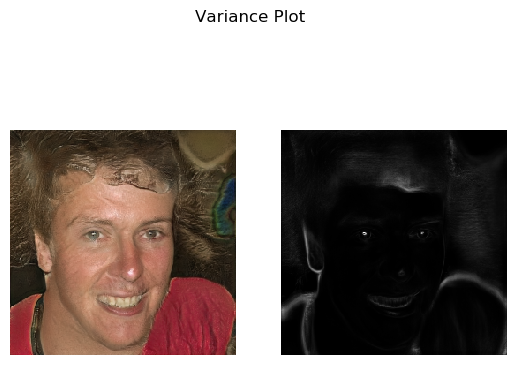

In [28]:
alpha = 1.0
steps = 6
noise = torch.randn(1, Z_DIM).to(DEVICE)
img = (gen(noise, alpha, steps)* 0.5 + 0.5).cpu().detach()[0].permute(1,2,0)

samples = []
for i in tqdm(range(0,100)):
    samples.append((gen(noise, alpha, steps)* 0.5 + 0.5).cpu().detach()[0].permute(1,2,0).numpy())
samples = np.array(samples)
a = samples.var(axis=0)
a = np.interp(a, (a.min(), a.max()), (0, +1)).mean(axis=2)

_,ax     = plt.subplots(1,2)
plt.suptitle('Variance Plot')
for x in ax:
    x.axis("off")

ax[0].imshow(img)
ax[1].imshow(a, cmap='gray')

plt.show()


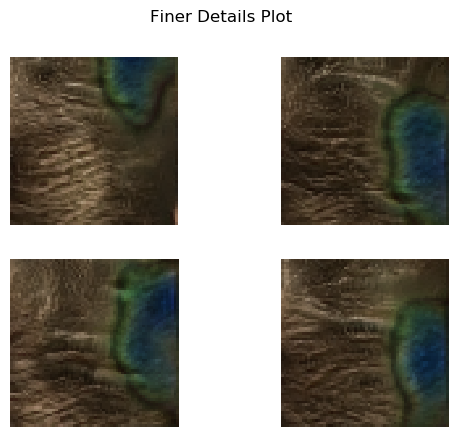

In [29]:
block_size = 64
sum_patches = a.reshape(a.shape[0]//block_size, block_size, a.shape[1]//block_size, block_size).sum(axis=(1, 3))
indice = np.unravel_index(np.argmax(sum_patches, axis=None), sum_patches.shape)

_, ax = plt.subplots(2,2)
plt.suptitle('Finer Details Plot')

trials = np.array([ samples[x][block_size*indice[0]:block_size*indice[0]+block_size,block_size*indice[1]:block_size*indice[1]+block_size, : ] for x in np.random.choice(np.arange(samples.shape[0]),4)])

for p in ax :
    for b in p:
        b.axis("off")

ax[0][0].imshow(trials[0])
ax[0][1].imshow(trials[1])
ax[1][0].imshow(trials[2])
ax[1][1].imshow(trials[3])



## PPL

In [34]:
def normalize(x):
    return x / torch.sqrt(x.pow(2).sum(1, keepdim=True))

def slerp(a,b,t):
    a = normalize(a)
    b = normalize(b)
    d = (a*b).sum(-1, keepdimepdim=True)
    p = t * torch.acos(d)
    
    c = normalize(b - d*a)
    d = a * torch.cos(p) + c * torch.sin(p)
    
    return normalize(d)

def lerp(a, b, t):
    return a + (b - a) * t


latent_dim = Z_DIM

percept = lpips.LPIPS(net="vgg").to(DEVICE)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /common/home/aaj116/.local/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [42]:
n_sample = 10000
eps = 1e-4
batch = 1
alpha = 1.0
steps = 6

distances = []

n_batch = n_sample // batch
resid = n_sample - (n_batch * batch)
batch_sizes = [batch] * n_batch + [resid]


In [43]:
with torch.no_grad():
    for batch in tqdm(batch_sizes):
        if batch == 0:
            continue
        
        inputs = torch.randn(batch*2, latent_dim).to(DEVICE)
        
        latent = gen.map(inputs)
        
        lerp_t = torch.rand(batch, device=DEVICE)

        latent_t0, latent_t1 = latent[::2], latent[1::2]
        latent_e0 = lerp(latent_t0, latent_t1, lerp_t[:, None])
        latent_e1 = lerp(latent_t0, latent_t1, lerp_t[:, None] + eps)
        
        latent_e = torch.stack([latent_e0, latent_e1],1).view(*latent.shape)
        
        image = gen(latent_e, alpha, steps)
        factor = image.shape[2] // 256

        if factor > 1:
            image = nn.functional.interpolate(
                image, size=(256, 256), mode="bilinear", align_corners=False
            )
        dist = percept(image[::2], image[1::2]).view(image.shape[0] // 2) / (
            eps ** 2
        )
        distances.append(dist.to("cpu").numpy())

100%|█████████████████████████████████████| 10001/10001 [04:56<00:00, 33.73it/s]


In [44]:
# distances = np.concatenate(distances, 0)

lo = np.percentile(distances, 1, interpolation="lower")
hi = np.percentile(distances, 99, interpolation="higher")
filtered_dist = np.extract(
np.logical_and(lo <= distances, distances <= hi), distances
)

print("ppl:", filtered_dist.mean())

ppl: 26100986.0


/tmp/ipykernel_806530/791791562.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  lo = np.percentile(distances, 1, interpolation="lower")
/tmp/ipykernel_806530/791791562.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  hi = np.percentile(distances, 99, interpolation="higher")
